In [4]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as ps
import matplotlib.pyplot as plt
import matplotlib as mpl

#For basemap:
import contextily as cx

#For regression:
import statsmodels.api as sm
import numpy as np
from patsy import dmatrices

import esda as esda
from esda.moran import Moran_Local
import splot as splot

#Plot spatial weights:
from libpysal.weights.contiguity import Queen
from splot.libpysal import plot_spatial_weights
from splot.esda import moran_scatterplot, plot_moran
from splot.esda import plot_local_autocorrelation

# For GWR
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
import os

In [8]:
os.chdir('/Users/meera/Documents/drugs/Data')
df = gpd.read_file('geo_od_nonull.geojson')
df.dtypes

log_Overdose_Rate_per_100k     float64
Pct_Age_lt_18                  float64
log_Pct_Black                  float64
Potential_Years_Lost           float64
Pct_Uninsured                  float64
log_PrimCarePhys_per_100k      float64
Pct_Child_in_1ParentHH         float64
Pct_Poverty                    float64
log_Spatial_Mean               float64
geometry                      geometry
dtype: object

In [11]:
y, X = dmatrices("log_Overdose_Rate_per_100k ~ Pct_Age_lt_18 + log_Pct_Black + Potential_Years_Lost + Pct_Uninsured +\
                 log_PrimCarePhys_per_100k + Pct_Child_in_1ParentHH +  Pct_Poverty + log_Spatial_Mean", 
                 data=df, return_type='dataframe')


mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                                OLS Regression Results                                
Dep. Variable:     log_Overdose_Rate_per_100k   R-squared:                       0.625
Model:                                    OLS   Adj. R-squared:                  0.625
Method:                         Least Squares   F-statistic:                     1669.
Date:                        Sun, 01 May 2022   Prob (F-statistic):               0.00
Time:                                18:21:15   Log-Likelihood:                -2774.1
No. Observations:                        8018   AIC:                             5566.
Df Residuals:                            8009   BIC:                             5629.
Df Model:                                   8                                         
Covariance Type:                    nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [21]:
y_pred_full = res.predict(X)

In [22]:
#putting the residuals in one column of a dataframe !! 
y = np.array(y)
y_pred_full = np.array(y_pred_full).reshape(8018,1)
resid = pd.DataFrame(y -  y_pred_full)
resid

,0
0,-0.368746
1,-0.682655
2,-0.837131
3,-0.208974
4,0.878448
...,...
8013,-0.038029
8014,0.115596
8015,0.034004
8016,0.477381


In [23]:
#Append it top the whole dataframe 
df = df.reset_index(drop = True)
df['Residuals'] = resid

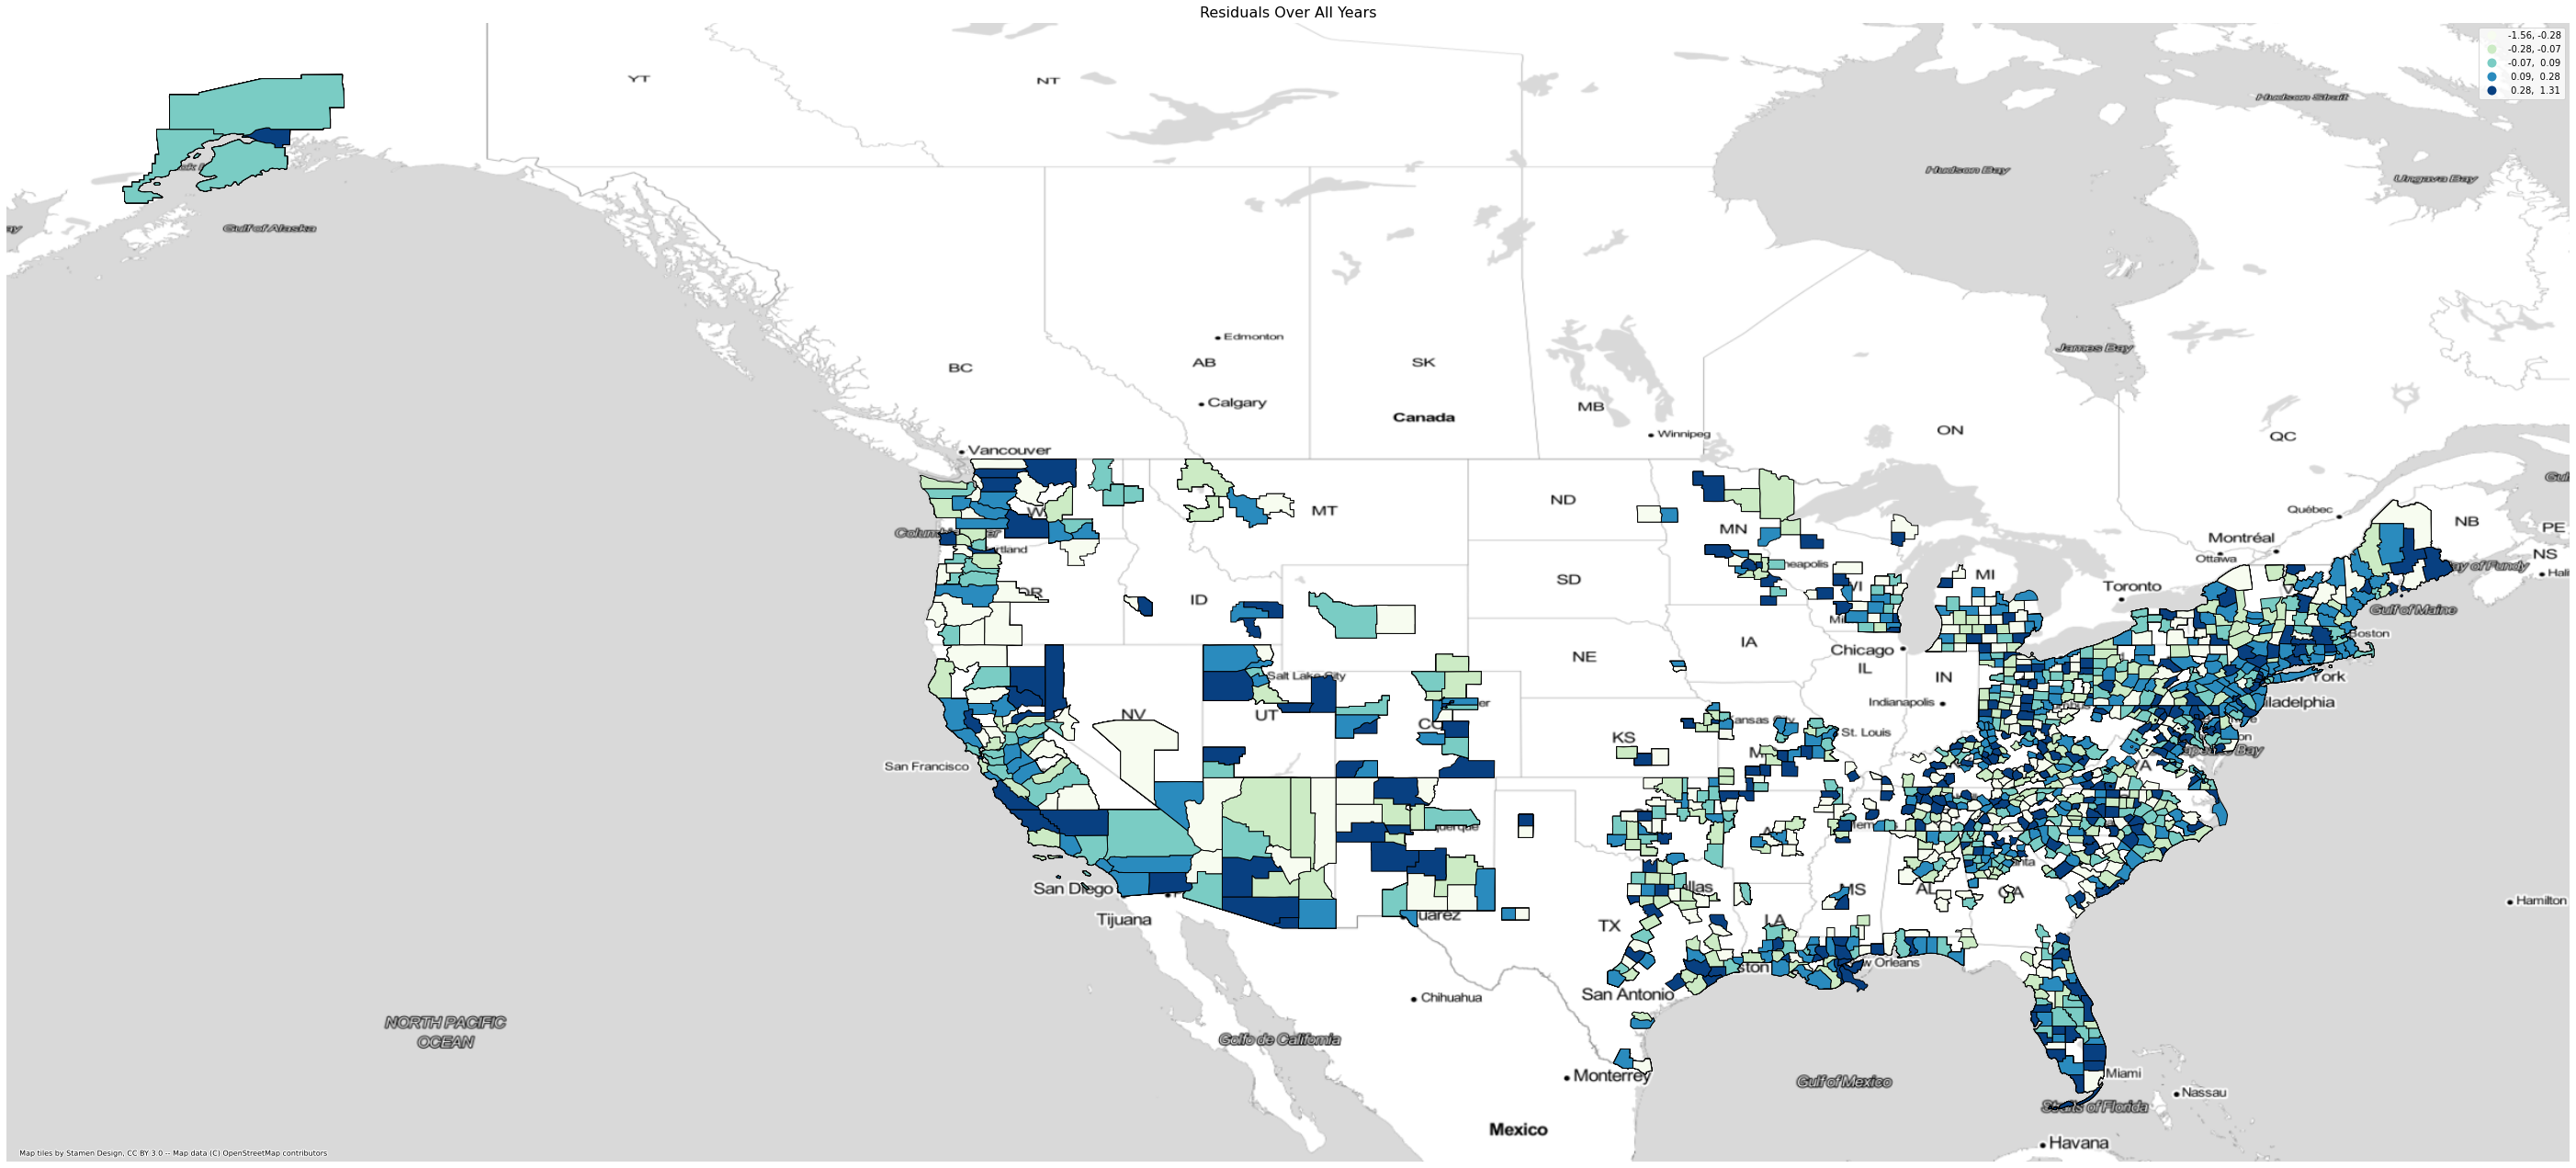

In [27]:
#now plot is on the map !!! 
#this will be across all of time 
f,ax = plt.subplots(1,1,figsize=(50,50))

df.plot(column='Residuals', legend=True, ax=ax,
        scheme="quantiles",  k=5, cmap='GnBu',edgecolor='black')

ax.set_title("Residuals Over All Years", fontsize=16)

ax.axis('off')

cx.add_basemap(ax, crs=df.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()

In [29]:
w = Queen.from_dataframe(df)
df_2 = df.drop(w.islands)
w2 = Queen.from_dataframe(df_2)

/Users/meera/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 40 disconnected components.
  warnings.warn(message)


In [31]:
#The Moran's I for the residuals 
y = df['Residuals']
y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I

0.07373760802702713

As a rule of thumb we can see that Moran's I should be less than 0.3 in order for it to be considered something that is significant. 

In [34]:
#Double checking the Moran's I value here for the response again 
y = df['log_Overdose_Rate_per_100k']
y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I

0.45518502381559756

In [35]:
#MORANS I FOR PREDICTORS
y = df['Pct_Age_lt_18']
y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I

0.5975728122537499

In [36]:
y = df['log_Pct_Black']
y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I

0.6911321187840473

In [38]:
y = df['Potential_Years_Lost']
y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I

0.6171366309347042

In [39]:
y = df['Pct_Uninsured']
y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I

0.5258988348500594

In [40]:
y = df['log_PrimCarePhys_per_100k']
y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I

0.21736027463623062

In [41]:
y = df['Pct_Child_in_1ParentHH']
y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I

0.3423822077150117

In [44]:
y = df['Pct_Poverty']
y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I

0.482516144933146

In [43]:
#lol this one may be stupid tho 

y = df['log_Spatial_Mean']
y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I

0.5704921069087169